In [853]:
# Descarga tu repositorio desde GitHub
!git clone https://github.com/Wmarbar/CProgram_incidencias.git

# Cambia de directorio para acceder a los archivos
%cd CProgram_incidencias

# Verifica que los archivos estén
!ls


Cloning into 'CProgram_incidencias'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 81 (delta 46), reused 9 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 2.76 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias/CProgram_incidencias
 constructor4_proyecto_II.ipynb   README.md
 input				 'Trabajo-CalidadDeDatos Ver4-2.pdf'
 logo_u.png


# __PROGRAMACIÓN PARA ANALÍTICA DE DATOS__

<img src="https://github.com/WMARBAR/CProgram_incidencias/blob/main/logo_u.png?raw=1" alt="Logo Universidad Central" width="300" />

> ## __PROYECTO: Estimación Área bajo la curva__

> ## Profesor: Jorge Victorino [jvictorinog@ucentral.edu.co](jvictorinog@ucentral.edu.co)<br>
> ## Estudiante: Sergio Andrés Sánchez Cárdenas [correo@ucentral.edu.co](mailto:correo@ucentral.edu.co)<br>
> ## Estudiante: Wilson Felipe Mártinez Barrantes [wmartinezb1@ucentral.edu.co](jvictorinog@ucentral.edu.co)<br>
> ## Grupo: 5 <br>
> ### Facultad de Ingeniería y Ciencias Básicas <br>
> ### Universidad Central <br>
> <br>

---


# FUNCTIONS

In [854]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import unicodedata
def load_excel(path):

 df_incidentes = pd.read_excel(path)
 return df_incidentes


def delta_dates(df, col1, col2):
    try:
        # Verificar si las columnas existen
        if col1 not in df.columns or col2 not in df.columns:
            print(f"Las columnas '{col1}' o '{col2}' no existen en el DataFrame.")
            return df

        # Convertir columnas a datetime con coerción
        df[col1] = pd.to_datetime(df[col1], errors='coerce')
        df[col2] = pd.to_datetime(df[col2], errors='coerce')

        # Avisar si hay muchas fechas inválidas (pero continuar)
        if df[col1].isna().any():
            print(f"Algunos valores en '{col1}' no son fechas válidas y se marcarán como NaT.")
        if df[col2].isna().any():
            print(f"Algunos valores en '{col2}' no son fechas válidas y se marcarán como NaT.")

        # Calcular diferencia en días (donde ambas fechas sean válidas)
        nueva_col = f"{col1}_{col2}_days"
        df[nueva_col] = (df[col2] - df[col1]).dt.days

        return df

    except Exception as e:
        print(f"Error inesperado: {e}")
        return df

def key_generator(df, columnas):
    try:
        # Validar columnas
        for col in columnas:
            if col not in df.columns:
                print(f"La columna '{col}' no existe en el DataFrame.")
                return df

        # Nombre de la nueva columna
        nombre_key = '_'.join(columnas) + '_KEY'

        # Función de limpieza para cada valor
        def limpiar_valor(v):
            if isinstance(v, float) and v.is_integer():
                return str(int(v))
            return str(v)

        # Aplicar limpieza y concatenar
        df[nombre_key] = df[columnas].apply(lambda row: '_'.join(limpiar_valor(v) for v in row), axis=1)

        return df

    except Exception as e:
        print(f"Error inesperado: {e}")
        return df


def drop_nan_by_column(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return df

    df_limpio = df.dropna(subset=[col])
    return df_limpio


def deduplicar_incidentes(df, key_col='Incidente_Estructura_KEY', dias_col='Creacion_Inicio_days'):
    if key_col not in df.columns or dias_col not in df.columns:
        print(f"Las columnas '{key_col}' o '{dias_col}' no existen.")
        return df, pd.DataFrame()

    indices_a_conservar = []

    # Función para aplicar por grupo
    def resolver_grupo(grupo):
        sin_cero = grupo[grupo[dias_col] != 0]
        if not sin_cero.empty:
            idx = sin_cero.index[0]
        else:
            idx = grupo.index[0]
        indices_a_conservar.append(idx)
        return

    # Agrupar y marcar qué índices se deben conservar
    df.groupby(key_col, group_keys=False).apply(resolver_grupo)

    # Separar los que se quedan y los que se van
    df_filtrado = df.loc[indices_a_conservar].reset_index(drop=True)
    df_duplits = df.drop(index=indices_a_conservar).reset_index(drop=True)

    print(f"Registros conservados: {len(df_filtrado)} | Registros duplicados removidos: {len(df_duplits)}")

    return df_filtrado, df_duplits


def unique_validator(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return

    duplicados = df.duplicated(subset=[col]).sum()

    if duplicados > 0:
        print(f"Hay {duplicados} valores duplicados en la columna '{col}'.")
    else:
        print(f"Todos los valores en la columna '{col}' son únicos.")



def nan_detector_column(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return df

    df[f'{col}_NAN_DETECTOR'] = df[col].apply(lambda x: 1 if pd.isna(x) or (isinstance(x, str) and x.strip() == '') else 0)

    return df

def deduplicar_estructuras_por_vereda(df, key_col='Estructura', prioridad_col='Vereda'):
    # Validar que las columnas existan
    if key_col not in df.columns or prioridad_col not in df.columns:
        print(f"Las columnas '{key_col}' o '{prioridad_col}' no existen.")
        return df

    # Función para aplicar por grupo
    def resolver_grupo(grupo):
        con_vereda = grupo[grupo[prioridad_col].apply(lambda x: isinstance(x, str) and x.strip() != '') | grupo[prioridad_col].notna()]
        if not con_vereda.empty:
            return con_vereda.iloc[[0]]  # Uno cualquiera con vereda
        else:
            return grupo.iloc[[0]]  # Si no hay vereda, igual uno cualquiera

    # Aplicar la lógica por grupo
    df_filtrado = df.groupby(key_col, group_keys=False).apply(resolver_grupo).reset_index(drop=True)

    return df_filtrado


def limpiar_nombres_columnas(df):
    df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True)
    return df

def corregir_basura_columna(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return df

    def _fix_encoding(x):
        if isinstance(x, str):
            try:
                return x.encode('latin1').decode('utf-8')
            except Exception:
                return x
        return x

    df[col] = df[col].apply(_fix_encoding)
    return df

def merge_excluir_llave(df1, df2, llave_df1, llave_df2):
    # Verificar existencia de las columnas
    if llave_df1 not in df1.columns or llave_df2 not in df2.columns:
        print(f"Las llaves '{llave_df1}' o '{llave_df2}' no existen.")
        return df1

    # Hacer el merge completo primero
    df_merged = df1.merge(df2, left_on=llave_df1, right_on=llave_df2, how='left')

    # Eliminar la llave de df2 si es distinta a la de df1
    if llave_df1 != llave_df2:
        df_merged = df_merged.drop(columns=[llave_df2])

    return df_merged

def guardar_excel(df, nombre_archivo='salida.xlsx', sheet_name='Hoja1'):
    try:
        df.to_excel(nombre_archivo, index=False, sheet_name=sheet_name)
        print(f"Archivo guardado exitosamente como '{nombre_archivo}'.")
    except Exception as e:
        print(f"Error al guardar el archivo: {e}")


def marcar_estado_interes(df, col='Estado'):
    palabras_clave = ['GPRE', 'PRER', 'TAMB', 'GEAM', 'AMPO', 'GERE']
    # Usamos regex para buscar cualquiera de las palabras
    patron = '|'.join(palabras_clave)

    df['estado_interes'] = df[col].astype(str).str.contains(patron).astype(int)

    return df

def ones_selector(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return df

    df_filtrado = df[df[col] == 1].copy()
    return df_filtrado

def spliter(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe en el DataFrame.")
        return df

    # Separar por espacio
    nuevas_cols = df[col].astype(str).str.split(expand=True)

    # Renombrar columnas nuevas con sufijos: col_1, col_2, etc.
    nuevas_cols.columns = [f"{col}_{i+1}" for i in range(nuevas_cols.shape[1])]

    # Unir al DataFrame original
    df_expandido = pd.concat([df, nuevas_cols], axis=1)

    return df_expandido

def contar_columnas_con_dato(df, columnas):
    # Validar que las columnas existan
    for col in columnas:
        if col not in df.columns:
            print(f"La columna '{col}' no existe en el DataFrame.")
            return df

    # Contar columnas con dato no nulo y no vacío
    df['Estados'] = df[columnas].apply(
        lambda fila: sum(1 for x in fila if pd.notna(x) and (not isinstance(x, str) or x.strip() != '')),
        axis=1
    )

    return df

def conteo_duplicados_por_llave(df, llave):
    if llave not in df.columns:
        print(f"La columna '{llave}' no existe en el DataFrame.")
        return pd.DataFrame()

    # Contar ocurrencias por cada valor único de la llave
    conteo = df[llave].value_counts().reset_index()
    conteo.columns = [llave, 'Repeticiones']

    return conteo

def limpiar_espacios_en_columnas(df, columnas):
    for col in columnas:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: "" if isinstance(x, str) and x.strip() == "" else x)
        else:
            print(f"La columna '{col}' no existe en el DataFrame.")
    return df

def prioridadchanger(df, col_prioridad='Prioridad', col_referencia='Inicio_Cierre_days'):
    # Mapeo de prioridad a días
    mapeo_dias = {
        'Semana': 7,
        'Mes': 30,
        'Trimestre': 90,
        'Semestre': 180,
        'Año': 365,
        'Dos años': 730,
        'Tres años': 1095,
        'Seis años': 2190
    }

    # Calcular mediana para los valores NaN
    mediana_referencia = df[col_referencia].median()

    # Crear nueva columna con los días
    df['prioridad_days'] = df[col_prioridad].map(mapeo_dias)

    # Rellenar NaN con la mediana de la duración real
    df['prioridad_days'] = df['prioridad_days'].fillna(mediana_referencia)

    return df


def numeric_feats(df, col):
    if col not in df.columns:
        print(f"La columna '{col}' no existe.")
        return

    if not pd.api.types.is_numeric_dtype(df[col]):
        print(f"La columna '{col}' no es numérica.")
        return

    serie = df[col]

    resumen = {
        'Columna': col,
        'Valores únicos': serie.nunique(),
        'Nulos': serie.isna().sum(),
        'Máximo': serie.max(),
        'Mínimo': serie.min(),
        'Más frecuente': serie.mode().iloc[0] if not serie.mode().empty else None,
        'Frecuencia del más frecuente': serie.value_counts().iloc[0] if not serie.mode().empty else None,
        'Media': serie.mean(),
        'Mediana': serie.median(),
        'Desviación estándar': serie.std()
    }

    return pd.DataFrame([resumen])




def evaluar_prioridad_cumplida(df, prioridad_col='prioridad_days',
                                cierre_col='Creacion_Cierre_days',
                                inicio_cierre_col='Inicio_Cierre_days',
                                fecha_creacion_col='Creacion',
                                fecha_inicio_col='Inicio'):
    # Validar columnas
    columnas = [prioridad_col, cierre_col, inicio_cierre_col, fecha_creacion_col, fecha_inicio_col]
    for col in columnas:
        if col not in df.columns:
            print(f"La columna '{col}' no existe.")
            return df

    # Convertir fechas a datetime
    df[fecha_creacion_col] = pd.to_datetime(df[fecha_creacion_col], errors='coerce')
    df[fecha_inicio_col] = pd.to_datetime(df[fecha_inicio_col], errors='coerce')

    # Calcular días hasta fecha de corte
    hoy = pd.to_datetime("2019-05-06")
    df['dias_desde_creacion'] = (hoy - df[fecha_creacion_col]).dt.days
    df['dias_desde_inicio'] = (hoy - df[fecha_inicio_col]).dt.days

    # Rellenar NaNs en los días reales con días hasta hoy
    df[cierre_col] = df[cierre_col].fillna(df['dias_desde_creacion'])
    df[inicio_cierre_col] = df[inicio_cierre_col].fillna(df['dias_desde_inicio'])

    # Calcular delta contra prioridad
    df['delta_creacion_cierre_vs_prioridad'] = df[cierre_col] - df[prioridad_col]
    df['delta_inicio_cierre_vs_prioridad'] = df[inicio_cierre_col] - df[prioridad_col]

    # Evaluación: ¿se cumplió la prioridad?
    df['cumplimiento_creacion'] = df['delta_creacion_cierre_vs_prioridad'].apply(
        lambda x: 'Cumplida' if x <= 0 else 'Incumplida'
    )

    df['cumplimiento_inicio'] = df['delta_inicio_cierre_vs_prioridad'].apply(
        lambda x: 'Cumplida' if x <= 0 else 'Incumplida'
    )

    return df



def categoc_features(df, col):
    """
    Genera un resumen estadístico de una variable categórica:
    - Total por categoría
    - Porcentaje sobre el total
    - Porcentaje acumulado estilo Pareto

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        col (str): Nombre de la columna categórica.

    Returns:
        pd.DataFrame: Resumen con columnas ['Total', 'Porcentaje', '%_Acumulado']
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe en el DataFrame.")
        return pd.DataFrame()

    total = df[col].notna().sum()
    conteo = df[col].value_counts(dropna=True).sort_values(ascending=False)
    porcentaje = (conteo / total * 100).round(2)
    pareto = porcentaje.cumsum().round(2)

    resumen = pd.DataFrame({
        'Total': conteo,
        'Porcentaje': porcentaje,
        '%_Acumulado': pareto
    }).reset_index().rename(columns={'index': col})

    return resumen



def boxplot_variable(df, col):
    """
    Crea un boxplot bonito con matplotlib mostrando mediana y promedio.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        col (str): Nombre de la columna numérica a graficar.

    Returns:
        None. Muestra el gráfico.
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe.")
        return

    data = df[col].dropna()

    if data.empty:
        print("❌ No hay datos válidos para graficar.")
        return

    median = data.median()
    mean = data.mean()

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                flierprops=dict(markerfacecolor='gray', marker='o', markersize=5))

    plt.axvline(median, color='red', linestyle='--', label=f'Mediana = {median:.2f}')
    plt.axvline(mean, color='green', linestyle='-.', label=f'Promedio = {mean:.2f}')

    plt.title(f'Boxplot de {col}', fontsize=14)
    plt.xlabel(col)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def pieplot_binaria(df, col, label_1, label_0):
    """
    Crea un gráfico de torta para una columna binaria con etiquetas personalizadas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        col (str): Nombre de la columna binaria (con valores 0 y 1).
        label_1 (str): Etiqueta para los valores 1.
        label_0 (str): Etiqueta para los valores 0.

    Returns:
        None. Muestra el gráfico.
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe en la base de datos.")
        return

    # Validar que sea binaria
    valores_unicos = df[col].dropna().unique()
    if not set(valores_unicos).issubset({0, 1}):
        print("❌ La columna no es binaria (debe contener solo 0 y 1).")
        return

    conteo = df[col].value_counts().sort_index()
    etiquetas = [label_0, label_1]
    valores = [conteo.get(0, 0), conteo.get(1, 0)]

    plt.figure(figsize=(6, 6))
    plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
    plt.title(f'Distribución binaria de "{col}"', fontsize=14)
    plt.axis('equal')  # Hace que sea un círculo perfecto
    plt.show()

def pareto(df, col):
    """
    Genera un gráfico de Pareto para una columna categórica, mostrando las categorías
    que acumulan hasta el 80% más una adicional.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        col (str): Nombre de la columna categórica.

    Returns:
        None. Muestra el gráfico.
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe en el DataFrame.")
        return

    # Recuento y porcentajes
    conteo = df[col].value_counts()
    porcentaje = conteo / conteo.sum()
    porcentaje_acumulado = porcentaje.cumsum()

    # Seleccionar categorías hasta 80% + 1 adicional
    categorias_pareto = porcentaje_acumulado[porcentaje_acumulado <= 0.80].index.tolist()
    if len(porcentaje_acumulado) > len(categorias_pareto):
        categorias_pareto.append(porcentaje_acumulado.index[len(categorias_pareto)])

    # Subconjunto de datos para graficar
    conteo_filtrado = conteo.loc[categorias_pareto]
    porcentaje_acum_filtrado = porcentaje_acumulado.loc[categorias_pareto]

    # Gráfico de barras (frecuencias)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.bar(conteo_filtrado.index, conteo_filtrado.values, color='skyblue')
    ax1.set_ylabel('Frecuencia', color='black')
    ax1.tick_params(axis='x', rotation=45)

    # Línea de porcentaje acumulado
    ax2 = ax1.twinx()
    ax2.plot(conteo_filtrado.index, porcentaje_acum_filtrado.values * 100, color='red', marker='o')
    ax2.set_ylabel('% Acumulado', color='red')
    ax2.set_ylim(0, 110)

    # Título
    plt.title(f"Diagrama de Pareto - {col}")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def expandir_fecha(df, columna_fecha):
    """
    Expande una columna datetime en: año, mes, año-mes y un contador cronológico de meses únicos.

    Args:
        df (pd.DataFrame): DataFrame original.
        columna_fecha (str): Nombre de la columna tipo datetime.

    Returns:
        pd.DataFrame: DataFrame con columnas nuevas agregadas.
    """
    import pandas as pd

    if columna_fecha not in df.columns:
        raise ValueError(f"La columna '{columna_fecha}' no existe en el DataFrame.")

    if not pd.api.types.is_datetime64_any_dtype(df[columna_fecha]):
        try:
            df[columna_fecha] = pd.to_datetime(df[columna_fecha])
        except Exception as e:
            raise ValueError(f"No se pudo convertir la columna '{columna_fecha}' a datetime: {e}")

    # Expandir columnas básicas
    df[f"{columna_fecha}_year"] = df[columna_fecha].dt.year
    df[f"{columna_fecha}_month"] = df[columna_fecha].dt.month
    df[f"{columna_fecha}_year_month"] = df[columna_fecha].dt.to_period('M').astype(str)

    # Crear mapeo de fechas únicas ordenadas → contador de 1 en adelante
    fechas_ordenadas = sorted(df[f"{columna_fecha}_year_month"].unique())
    mapa_orden = {fecha: i+1 for i, fecha in enumerate(fechas_ordenadas)}

    df[f"{columna_fecha}_month_counter"] = df[f"{columna_fecha}_year_month"].map(mapa_orden)

    return df


def normalizar_texto(texto):
    if pd.isna(texto):
        return texto
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto.upper().strip()


def grafico_tendencia_anual(df, columna_anio, columna_conteo):
    """
    Genera una línea de tendencia anual sumando los valores de la columna_conteo por año.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columna_anio (str): Nombre de la columna con los años.
        columna_conteo (str): Columna con los valores a sumar por año.

    Returns:
        None. Muestra la gráfica.
    """
    if columna_anio not in df.columns or columna_conteo not in df.columns:
        print(f"❌ Columnas no encontradas: '{columna_anio}' o '{columna_conteo}'")
        return

    # Agrupar por año y sumar
    resumen = df.groupby(columna_anio)[columna_conteo].sum().sort_index()

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(resumen.index, resumen.values, marker='o', color='black', linewidth=2)
    plt.xlabel("Año", fontsize=12)
    plt.ylabel("Total Incidentes", fontsize=12)
    plt.title("Tendencia anual de incidentes", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(resumen.index, rotation=45)
    plt.tight_layout()
    plt.show()

def tendencia_temporal(df, col_fecha, col_conteo, step=3):
    """
    Genera una gráfica de línea temporal legible agrupando por mes.

    Args:
        df (pd.DataFrame): Base de datos con los datos.
        col_fecha (str): Nombre de la columna tipo datetime.
        col_conteo (str): Columna numérica a sumar (por ejemplo, incidentes).
        step (int): Intervalo de etiquetas del eje X a mostrar (por defecto 3).
    """
    if col_fecha not in df.columns or col_conteo not in df.columns:
        print("❌ Alguna de las columnas no existe.")
        return

    # Asegurar que la columna sea datetime
    df = df.copy()
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')

    # Agrupar por mes (como periodo) y sumar
    df['mes'] = df[col_fecha].dt.to_period('M')
    tendencia = df.groupby('mes')[col_conteo].sum().reset_index()
    tendencia['mes'] = tendencia['mes'].dt.to_timestamp()  # Convertir a timestamp

    # Gráfica
    plt.figure(figsize=(14, 6))
    plt.plot(tendencia['mes'], tendencia[col_conteo], marker='o', color='black', linewidth=2)

    # Mejorar visibilidad de los labels del eje X
    plt.xticks(ticks=tendencia['mes'][::step], labels=[d.strftime('%Y-%m') for d in tendencia['mes'][::step]], rotation=45, ha='right')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.title(f'Tendencia Temporal de {col_conteo} por Mes', fontsize=14)
    plt.xlabel('Mes')
    plt.ylabel(col_conteo)
    plt.tight_layout()
    plt.show()


def boxplot_filtrado(df, col_numerica, col_filtro, valor_filtro):
    """
    Genera un boxplot con líneas de media y mediana, filtrando por una condición.

    Args:
        df (pd.DataFrame): Base de datos.
        col_numerica (str): Columna numérica a graficar.
        col_filtro (str): Columna para filtrar (ej: cierre detectado).
        valor_filtro (int, str): Valor del filtro (ej: 1 para cerrados).

    Returns:
        None. Muestra la gráfica.
    """
    if col_numerica not in df.columns or col_filtro not in df.columns:
        print("❌ Columnas no encontradas.")
        return

    data = df[df[col_filtro] == valor_filtro][col_numerica].dropna()

    if data.empty:
        print("❌ No hay datos válidos para graficar.")
        return

    mediana = data.median()
    media = data.mean()

    plt.figure(figsize=(10, 4))
    plt.boxplot(data, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                flierprops=dict(markerfacecolor='gray', marker='o', markersize=5))

    plt.axvline(mediana, color='red', linestyle='--', label=f'Mediana: {mediana:.1f}')
    plt.axvline(media, color='blue', linestyle='--', label=f'Media: {media:.1f}')

    plt.title(f'Boxplot de {col_numerica} (filtrado por {col_filtro}={valor_filtro})', fontsize=12)
    plt.xlabel(col_numerica)
    plt.legend()
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def dispersion_con_r2(df, col_x, col_y):
    """
    Genera un scatter plot entre dos columnas numéricas y muestra la recta de regresión y R².

    Args:
        df (pd.DataFrame): Base de datos.
        col_x (str): Nombre de la columna del eje X.
        col_y (str): Nombre de la columna del eje Y.
    """
    if col_x not in df.columns or col_y not in df.columns:
        print("Alguna de las columnas no existe.")
        return

    datos = df[[col_x, col_y]].dropna()
    if datos.empty:
        print("No hay datos válidos para graficar.")
        return

    x = datos[col_x].values
    y = datos[col_y].values

    # Calcular regresión lineal
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)
    y_pred = poly1d_fn(x)

    # Calcular R² manualmente
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Graficar
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', alpha=0.6, label='Datos')
    plt.plot(x, y_pred, color='black', linestyle='--', label=f'Regresión (R² = {r2:.2f})')

    plt.title(f'Dispersión: {col_x} vs {col_y}', fontsize=14)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def dispersion_con_r2_colores(df, col_x, col_y, col_categoria=None):
    """
    Genera un scatter plot entre dos columnas numéricas, con línea de regresión y R².
    Si se proporciona una columna categórica, colorea los puntos según su categoría.

    Args:
        df (pd.DataFrame): Base de datos.
        col_x (str): Columna del eje X.
        col_y (str): Columna del eje Y.
        col_categoria (str, opcional): Columna categórica para colorear los puntos.
    """
    columnas = [col_x, col_y] + ([col_categoria] if col_categoria else [])
    for col in [col_x, col_y] + ([col_categoria] if col_categoria else []):
        if col and col not in df.columns:
            print(f"❌ La columna '{col}' no existe.")
            return

    datos = df[columnas].dropna()
    if datos.empty:
        print("❌ No hay datos válidos para graficar.")
        return

    x = datos[col_x].values
    y = datos[col_y].values

    # Calcular regresión lineal
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)
    y_pred = poly1d_fn(x)

    # Calcular R²
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Graficar
    plt.figure(figsize=(10, 6))

    if col_categoria:
        categorias = datos[col_categoria].unique()
        for cat in categorias:
            subset = datos[datos[col_categoria] == cat]
            plt.scatter(subset[col_x], subset[col_y], label=str(cat), alpha=0.6)
    else:
        plt.scatter(x, y, color='blue', alpha=0.6, label='Datos')

    plt.plot(x, y_pred, color='black', linestyle='--', label=f'Regresión (R² = {r2:.2f})')
    plt.title(f'Dispersión: {col_x} vs {col_y}', fontsize=14)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def crear_columna_binaria_cumplida(df, col):
    """
    Crea una columna binaria basada en si el valor es 'Cumplida' (1) o 'Incumplida' (0).

    Args:
        df (pd.DataFrame): DataFrame original.
        col (str): Nombre de la columna categórica a convertir.

    Returns:
        pd.DataFrame: DataFrame con la nueva columna binaria.
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe.")
        return df

    nueva_col = f"{col}_bins"
    df[nueva_col] = df[col].apply(lambda x: 1 if str(x).strip().lower() == 'cumplida' else 0)
    return df

def chi_square_pval(df, col1, col2):
    """
    Calcula el p-valor de una prueba chi-cuadrado entre dos columnas categóricas
    y devuelve una interpretación cualitativa de la relación.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        col1 (str): Primera columna categórica.
        col2 (str): Segunda columna categórica.

    Returns:
        tuple: (p-valor, interpretación cualitativa)
    """
    if col1 not in df.columns or col2 not in df.columns:
        raise ValueError("❌ Una o ambas columnas no existen en el DataFrame.")

    tabla = pd.crosstab(df[col1], df[col2])
    _, p_valor, _, _ = chi2_contingency(tabla)

    if p_valor < 0.01:
        interpretacion = "relación alta"
    elif p_valor < 0.05:
        interpretacion = "relación media"
    else:
        interpretacion = "relación baja"

    return p_valor, interpretacion

def histograma_variable(df, col):
    """
    Genera un histograma con matplotlib para una columna numérica de un DataFrame.

    Args:
        df (pd.DataFrame): Base de datos.
        col (str): Nombre de la columna numérica a graficar.

    Returns:
        None. Muestra el gráfico.
    """
    if col not in df.columns:
        print(f"❌ La columna '{col}' no existe.")
        return

    data = df[col].dropna()

    if data.empty:
        print("❌ No hay datos válidos para graficar.")
        return

    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def boxplot_desfase(df, columna_delta):
    import matplotlib.pyplot as plt

    data = df[columna_delta].dropna()
    plt.figure(figsize=(8, 4))
    plt.boxplot(data, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))
    plt.axvline(0, color='black', linestyle='--', label='Límite de prioridad')
    plt.title(f'Boxplot del Desfase: {columna_delta}')
    plt.xlabel('Días de desfase')
    plt.legend()
    plt.tight_layout()
    plt.show()



def calcular_fecha_limite(df, col_fecha, col_dias):
    """
    Suma una cantidad de días (col_dias) a una fecha (col_fecha) y crea una nueva columna con la fecha límite.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        col_fecha (str): Nombre de la columna de tipo datetime.
        col_dias (str): Nombre de la columna numérica (días a sumar).

    Returns:
        pd.DataFrame: DataFrame con la nueva columna '<col_fecha>_limite'.
    """
    if col_fecha not in df.columns or col_dias not in df.columns:
        raise ValueError("❌ Una o ambas columnas no existen en el DataFrame.")

    df = df.copy()
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')

    nueva_col = f"{col_fecha}_limite"
    df[nueva_col] = df[col_fecha] + pd.to_timedelta(df[col_dias], unit='D')

    return df

import pandas as pd

def evaluar_vencimiento(df, col_limite, col_cierre, fecha_referencia='2019-05-06'):
    """
    Evalúa si una incidencia está vencida comparando la fecha de cierre con la fecha límite.
    Si la fecha de cierre es NaT, se usa una fecha de referencia fija.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        col_limite (str): Nombre de la columna con la fecha límite esperada.
        col_cierre (str): Nombre de la columna con la fecha real de cierre.
        fecha_referencia (str): Fecha fija para comparar si no hay cierre (formato 'YYYY-MM-DD').

    Returns:
        pd.DataFrame: DataFrame con nueva columna 'vencido' (1 si está vencido, 0 si no).
    """
    if col_limite not in df.columns or col_cierre not in df.columns:
        raise ValueError("❌ Una o ambas columnas no existen en el DataFrame.")

    df = df.copy()
    df[col_limite] = pd.to_datetime(df[col_limite], errors='coerce')
    df[col_cierre] = pd.to_datetime(df[col_cierre], errors='coerce')
    ref_date = pd.to_datetime(fecha_referencia)

    # Si la fecha de cierre está vacía, usar la fecha de referencia
    fecha_comparacion = df[col_cierre].fillna(ref_date)

    # Evaluar si venció (si cerró después de la fecha límite)
    df['vencido'] = (fecha_comparacion > df[col_limite]).astype(int)

    return df


def hmap(df, col_tipo, col_depto):
    """
    Genera un mapa de calor con los porcentajes de tipos de incidentes por departamento.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        col_tipo (str): Columna con el tipo de incidente.
        col_depto (str): Columna con el nombre del departamento.

    Returns:
        None: Muestra el heatmap.
    """
    if col_tipo not in df.columns or col_depto not in df.columns:
        print("❌ Una o ambas columnas no existen.")
        return

    # Tabla cruzada de conteo
    tabla = pd.crosstab(df[col_depto], df[col_tipo])

    # Convertir a porcentaje por fila (por departamento)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

    # Graficar heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(tabla_pct, cmap='YlGnBu', aspect='auto')
    plt.colorbar(label='Porcentaje (%)')

    plt.xticks(ticks=range(tabla_pct.shape[1]), labels=tabla_pct.columns, rotation=45, ha='right')
    plt.yticks(ticks=range(tabla_pct.shape[0]), labels=tabla_pct.index)

    plt.title('Mapa de Calor: % Tipos de Incidente por Departamento')
    plt.xlabel('Tipo de Incidente')
    plt.ylabel('Departamento')
    plt.tight_layout()
    plt.show()

def analizar_incidentes_espacial(df):
    """
    Analiza la ocurrencia de incidentes por tipo y espacialmente
    por departamento, municipio y vereda.

    Parámetros:
    df: DataFrame con columnas 'Tipo_incidente', 'departamento', 'municipio', 'vereda'
    """
    # Copia y limpieza
    df = df.copy()
    for col in ['departamento', 'municipio', 'vereda']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.upper()

    print("="*60)
    print("ANÁLISIS DE INCIDENTES POR TIPO Y UBICACIÓN ESPACIAL")
    print("="*60)

    # 1. ANÁLISIS POR TIPO DE INCIDENTE
    print("\n1. ANÁLISIS POR TIPO DE INCIDENTE")
    print("-" * 40)

    tipos_incidente = df['Tipo_incidente'].value_counts()
    total_incidentes = len(df)

    print("Frecuencia de incidentes por tipo:")
    for tipo, count in tipos_incidente.items():
        porcentaje = (count / total_incidentes) * 100
        print(f"  {tipo}: {count:,} incidentes ({porcentaje:.2f}%)")

    # Visualización: solo gráfico de barras
    plt.figure(figsize=(10, 6))
    tipos_incidente.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Frecuencia de Incidentes por Tipo', fontsize=14, fontweight='bold')
    plt.xlabel('Tipo de Incidente')
    plt.ylabel('Número de Incidentes')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# CARGA DE ARCHIVOS

In [855]:

df_incidentes = load_excel("./input/incidentes1.xlsx")
df_incidentes_original=load_excel("./input/incidentes1.xlsx")
df_estructura = load_excel("./input/estructura1.xlsx")

# 1. ANÁLISIS PREELIMINAR


## 1.1. ARREGLO DE LA DATA INCIDENCIAS

In [856]:
#1. Marcar estado:
df_incidentes=marcar_estado_interes(df_incidentes,'Estado')
#2. Seleccionar estados de interes:
df_incidentes=ones_selector(df_incidentes,'estado_interes')
# df_incidentes es la base de datos que se editará

#3. Reservar data original con nulls y duplicados para comparar despues:
df_incidentes_original=marcar_estado_interes(df_incidentes_original,'Estado')
df_incidentes_original=ones_selector(df_incidentes_original,'estado_interes')

## 1.2. TRATAMIENTO DE df_incidentes (Base de datos con la cantidad de incidencias registradas)

In [857]:
#1. Calcular la diferencia de dias entre las fechas de Creacion, Inicio y Cierre de la incidencia
df_incidentes=delta_dates(df_incidentes,'Creacion','Inicio')
df_incidentes=delta_dates(df_incidentes,'Creacion','Cierre')
df_incidentes=delta_dates(df_incidentes,'Inicio','Cierre')
#2. Crear una llave para asegurar que cada Incidente tenga una estructura unica asignada
df_incidentes=key_generator(df_incidentes,['Incidente','Estructura'])
#3. Eliminar NaN de estructuras ya que no puede haber una incidencia sin estructura
df_incidentes=drop_nan_by_column(df_incidentes,'Estructura')
#4. Eliminar duplicados de La columna incidentes en base a la columna Incidente_Estructura_KEY (llave entre incidente y estructura)
# Adicional se crea la base de datos df_incidentes_dups que contiene los duplicados que se eliminaron.
df_incidentes, df_incidentes_dups =deduplicar_incidentes(df_incidentes)
#5. La fecha de cierre tiene NaNs que se podrian traducir como incidencias no cerradas por lo que se deben marcar para calcularlas
df_incidentes=nan_detector_column(df_incidentes,'Cierre')
#6. Garantizar que las columnas no tengan espacios incomodos
df_incidentes=limpiar_nombres_columnas(df_incidentes)
#7. Garantizar una columna contadora para facilitar el analisis
df_incidentes['incidentes_counter']=1
#8. Expanción de fecha
df_incidentes=expandir_fecha(df_incidentes,'Creacion')
df_incidentes=expandir_fecha(df_incidentes,'Inicio')



Algunos valores en 'Cierre' no son fechas válidas y se marcarán como NaT.
Algunos valores en 'Cierre' no son fechas válidas y se marcarán como NaT.
Registros conservados: 3118 | Registros duplicados removidos: 1398


<ipython-input-854-365aec7274a0>:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(key_col, group_keys=False).apply(resolver_grupo)


## 1.3. ANALISIS DE INCIDENTES DUPLICADOS

In [858]:
base_nodup=len(df_incidentes) #df_incidentes es la base arreglada con incidencias unicas
base_dup=len(df_incidentes_dups) #df_incidentes_dups fue lo que se eliminó de df_incidentes
conteo_duplicados_por_llave(df_incidentes_original,'Incidente')# Aqui se hace un breve analisis de la data sin tratar

,Incidente,Repeticiones
0,2985102,10
1,2561196,8
2,2516568,8
3,2418967,8
4,2549859,8
...,...,...
3133,1618956,1
3134,1749655,1
3135,1643965,1
3136,1749630,1


In [859]:
print(f'TOTAL DE LA BASE (con duplicados) : {base_nodup+base_dup}')
print(f'TOTAL DE LA BASE (sin duplicados) : {base_nodup}')
print(f'REGISTROS UNICOS : {base_nodup}')
print(f'REGISTROS DUPLICADOS : {base_dup}')
print(f'% DUPLICADOS : {round((base_dup / (base_nodup + base_dup)) * 100, 2)}%')


TOTAL DE LA BASE (con duplicados) : 4516
TOTAL DE LA BASE (sin duplicados) : 3118
REGISTROS UNICOS : 3118
REGISTROS DUPLICADOS : 1398
% DUPLICADOS : 30.96%


## 1.4. ANALISIS DE NULLS

In [860]:
# Datos Nulls en el df sin arreglar
df_incidentes_original.isna().sum()

,0
Incidente,0
Estructura,24
Tipo incidente,0
Estado,0
Prioridad,23
Creacion,0
Inicio,0
Cierre,1288
estado_interes,0


#### Después del filtrado y el ajuste de la base de datos, las columnas Prioridad y Cierre presentan valores nulos. En el caso de Prioridad, los valores nulos corresponden a incidentes que ya fueron cerrados y cuya resolución tomó menos de dos años. Se decidió conservar estos registros, ya que aunque posiblemente se omitió registrar la prioridad, las incidencias sí fueron gestionadas.


#### La columna cierre tiene nulls que se pueden interpretar como incidencias sin fecha de cierre o incidencias abiertas estos nulls se marcaron para analisis posteriores

In [861]:
# Datos Nulls en el df Arreglado
df_incidentes.isna().sum()

,0
Incidente,0
Estructura,0
Tipo_incidente,0
Estado,0
Prioridad,17
Creacion,0
Inicio,0
Cierre,743
estado_interes,0
Creacion_Inicio_days,0


## 1.5. TIPOS DE DATOS DTYPES

In [862]:
# dtypes del df arreglado
df_incidentes['Estructura']=df_incidentes['Estructura'].astype(int)
df_incidentes.dtypes

,0
Incidente,int64
Estructura,int64
Tipo_incidente,object
Estado,object
Prioridad,object
Creacion,datetime64[ns]
Inicio,datetime64[ns]
Cierre,datetime64[ns]
estado_interes,int64
Creacion_Inicio_days,int64


## 1.6. Base de datos de las Estructuras (Contiene informacion sociodemografica de las estructuras que puede ser analizadas con las insidencias)

#### 1.6.1 ARREGLO DE LA DATA ESTRUCTURAS

In [863]:
# 1.) Arreglar las columnas de las estructuras
df_estructura= limpiar_nombres_columnas(df_estructura)
# 2.) Me quedo solo con las estructuras que tengan
df_estructura= drop_nan_by_column(df_estructura,'Estructura')
# 3.) Eliminiar duplicados por id de Estructura y dejando aquellas que tengan la vereda
df_estructura= deduplicar_estructuras_por_vereda(df_estructura)
# 4.) Tratamiento de las palabras de la columna Depto
df_estructura['Depto'] = df_estructura['Depto'].apply(normalizar_texto)
df_estructura['Municipio'] = df_estructura['Municipio'].apply(normalizar_texto)
df_estructura['Vereda'] = df_estructura['Vereda'].apply(normalizar_texto)
# 5.) Tratamiento de las cordenadas
df_estructura['Latitud'] = df_estructura['Latitud'].replace(',', '.')
df_estructura['Longitud'] = df_estructura['Longitud'].replace(',', '.')


<ipython-input-854-365aec7274a0>:143: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtrado = df.groupby(key_col, group_keys=False).apply(resolver_grupo).reset_index(drop=True)


In [864]:
df_incidentes.columns

Index(['Incidente', 'Estructura', 'Tipo_incidente', 'Estado', 'Prioridad',
       'Creacion', 'Inicio', 'Cierre', 'estado_interes',
       'Creacion_Inicio_days', 'Creacion_Cierre_days', 'Inicio_Cierre_days',
       'Incidente_Estructura_KEY', 'Cierre_NAN_DETECTOR', 'incidentes_counter',
       'Creacion_year', 'Creacion_month', 'Creacion_year_month',
       'Creacion_month_counter', 'Inicio_year', 'Inicio_month',
       'Inicio_year_month', 'Inicio_month_counter'],
      dtype='object')

## 1.7. RESULTADO: Base de incidencias cruzada y completa con la informacion de estructuras

### 1.7.1. Merge de df_incidentes y df_estructura

In [865]:
df_merged= merge_excluir_llave(df_incidentes,df_estructura,'Estructura','Estructura')
df_merged=spliter(df_merged,'Estado')
df_merged=contar_columnas_con_dato(df_merged, ['Estado_1', 'Estado_2', 'Estado_3','Estado_4','Estado_5','Estado_6','Estado_7'])
df_merged['Estructura']=df_merged['Estructura'].astype(int)
df_merged = prioridadchanger(df_merged, 'Prioridad', 'Inicio_Cierre_days')

df_merged.dtypes


,0
Incidente,int64
Estructura,int64
Tipo_incidente,object
Estado,object
Prioridad,object
Creacion,datetime64[ns]
Inicio,datetime64[ns]
Cierre,datetime64[ns]
estado_interes,int64
Creacion_Inicio_days,int64


# 2. DIVISIÓN TIPOS DE VARIABLES

## 2.1.VARIABLES CATEGORICAS

In [866]:
df_merged=limpiar_espacios_en_columnas(df_merged, ['Tipo_incidente', 'Estado', 'Prioridad',
                                                   'Depto', 'Municipio', 'Vereda', 'Cia',
                                                   'Estado_1', 'Estado_2', 'Estado_3','Estado_4',
                                                   'Estado_5','Estado_6','Estado_7'])


### 2.1.1. VARIABLE MUNICIPIO

In [867]:
categoc_features(df_merged, 'Municipio')

,Municipio,Total,Porcentaje,%_Acumulado
0,SANTA MARAA,164,5.29,5.29
1,UBALA,163,5.26,10.55
2,POPAYAN,84,2.71,13.26
3,JAMUNDA,80,2.58,15.84
4,GUASCA,71,2.29,18.13
...,...,...,...,...
146,GUACHENA,1,0.03,99.82
147,MERCADERES,1,0.03,99.85
148,NOBSA,1,0.03,99.88
149,CAMPOHERMOSO,1,0.03,99.91


### 2.1.2. VARIABLE Tipo_incidente

In [868]:
categoc_features(df_merged, 'Tipo_incidente')

,Tipo_incidente,Total,Porcentaje,%_Acumulado
0,VEGETACIÓN,1499,48.08,48.08
1,CONSTRUCCIONES,1165,37.36,85.44
2,OBRAS,236,7.57,93.01
3,PERMISO INGRESO,125,4.01,97.02
4,INVASIÓN/EXPLANACION,61,1.96,98.98
5,INVASIÓN/EXPLANACION,32,1.03,100.01


### 2.1.3. VARIABLE Prioridad

In [869]:
categoc_features(df_merged, 'Prioridad')

,Prioridad,Total,Porcentaje,%_Acumulado
0,Año,1111,35.83,35.83
1,Tres años,467,15.06,50.89
2,Seis años,393,12.67,63.56
3,Semestre,356,11.48,75.04
4,Dos años,337,10.87,85.91
5,Trimestre,283,9.13,95.04
6,Mes,150,4.84,99.88
7,Semana,4,0.13,100.01


### 2.1.4. VARIABLE Fases

In [870]:
categoc_features(df_merged, 'Estado_3')

,Estado_3,Total,Porcentaje,%_Acumulado
0,GERE,717,53.39,53.39
1,GEAM,253,18.84,72.23
2,REAN,93,6.92,79.15
3,TAMB,88,6.55,85.70
4,PRER,51,3.80,89.50
5,ENPT,49,3.65,93.15
6,CO19,34,2.53,95.68
7,GPRE,23,1.71,97.39
8,EESP,16,1.19,98.58
9,AMPO,13,0.97,99.55


## 2.2. VARIABLES NUMERICAS

In [871]:
#Funcion que me entrega valores de tiempo de solución o tiempo en mora
df_merged=evaluar_prioridad_cumplida(df_merged)
df_merged=crear_columna_binaria_cumplida(df_merged,'cumplimiento_creacion')
df_merged=crear_columna_binaria_cumplida(df_merged,'cumplimiento_inicio')
df_merged=calcular_fecha_limite(df_merged,'Creacion', 'prioridad_days')
df_merged = evaluar_vencimiento(df_merged, 'Creacion_limite', 'Cierre')


### 2.2.1. Variable Creacion_Inicio_days: Diferencia entre la fecha de creación y el inicio de atención del incidente

In [872]:
numeric_feats(df_merged,'Creacion_Inicio_days')


,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,Creacion_Inicio_days,425,0,4270,0,0,2136,126.075369,0.0,463.011275


### 2.2.2. Variable Creacion_Cierre_days: Días transcurridos entre la creación y el cierre del incidente

In [873]:
numeric_feats(df_merged,'Creacion_Cierre_days')


,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,Creacion_Cierre_days,1190,0,4306.0,0.0,4253.0,77,804.92848,439.0,946.087659


### 2.2.3. Variable Inicio_Cierre_days: Días transcurridos entre el inicio de atención y el cierre del incidente

In [874]:
numeric_feats(df_merged,'Inicio_Cierre_days')


,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,Inicio_Cierre_days,1097,0,4306.0,-11.0,4253.0,66,678.853111,367.5,888.351822


### 2.2.4. Variable prioridad_days: Tiempo estimado para resolver un incidente según su prioridad asignada

In [875]:
numeric_feats(df_merged,'prioridad_days')


,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,prioridad_days,9,0,2190.0,7.0,365.0,1111,680.997434,365.0,656.229857


### 2.2.5. Variable delta_creacion_cierre_vs_prioridad: Diferencia entre días reales y días esperados según la prioridad

In [876]:

numeric_feats(df_merged,'delta_creacion_cierre_vs_prioridad')

,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,delta_creacion_cierre_vs_prioridad,1275,0,3928.0,-2060.0,2063.0,55,123.931046,11.0,698.879799


### 2.2.6. Variable delta_inicio_cierre_vs_prioridad: Diferencia entre días reales y días esperados según la prioridad

In [877]:
numeric_feats(df_merged,'delta_inicio_cierre_vs_prioridad')

,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,delta_inicio_cierre_vs_prioridad,1383,0,3928.0,-2190.0,2063.0,49,-2.144323,-40.0,752.041131


### 2.2.7. Variable Estados: Conteo de estados reportados para cada incidente

In [878]:
numeric_feats(df_merged,'Estados')

,Columna,Valores únicos,Nulos,Máximo,Mínimo,Más frecuente,Frecuencia del más frecuente,Media,Mediana,Desviación estándar
0,Estados,6,0,7,2,2,1775,2.557409,2.0,0.754247


# 3. LAS VARIABLES CATEGORICAS Depto, Municipio, Vereda fueron previamente depuradas con la función normalizar_texto que me estandariza los datos de texto. Estas variables se escogieron por su relevancia en la geolocalizacion de estructuras y por eso habia que asegurar la integridad de los datos.  

## 3.1. Tabla 1 depurada: INCIDENCIAS

In [879]:
df_incidentes

,Incidente,Estructura,Tipo_incidente,Estado,Prioridad,Creacion,Inicio,Cierre,estado_interes,Creacion_Inicio_days,...,Cierre_NAN_DETECTOR,incidentes_counter,Creacion_year,Creacion_month,Creacion_year_month,Creacion_month_counter,Inicio_year,Inicio_month,Inicio_year_month,Inicio_month_counter
0,1013287,19895382,CONSTRUCCIONES,INIC GERE,NaN,2017-05-27,2017-05-27,2017-05-27,1,0,...,0,1,2017,5,2017-05,126,2017,5,2017-05,126
1,1013844,19891790,CONSTRUCCIONES,INIC GERE,Semestre,2017-05-26,2017-05-26,2017-05-27,1,0,...,0,1,2017,5,2017-05,126,2017,5,2017-05,126
2,1013896,19895083,CONSTRUCCIONES,INIC GEAM,Tres años,2017-05-26,2017-05-26,NaT,1,0,...,1,1,2017,5,2017-05,126,2017,5,2017-05,126
3,1014406,19895026,CONSTRUCCIONES,INIC GERE,Trimestre,2017-05-25,2017-05-27,2017-06-25,1,2,...,0,1,2017,5,2017-05,126,2017,5,2017-05,126
4,1014407,19895627,CONSTRUCCIONES,INIC COND GEAM,Semestre,2017-05-25,2017-05-28,NaT,1,3,...,1,1,2017,5,2017-05,126,2017,5,2017-05,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2996180,19892289,VEGETACIÓN,INIC ENPT GERE,Año,2013-08-03,2013-08-03,2015-11-23,1,0,...,0,1,2013,8,2013-08,81,2013,8,2013-08,81
3114,2996561,19892465,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-14,1,0,...,0,1,2013,8,2013-08,81,2013,8,2013-08,81
3115,2996571,19892471,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-19,1,0,...,0,1,2013,8,2013-08,81,2013,8,2013-08,81
3116,2996576,19892460,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-14,1,0,...,0,1,2013,8,2013-08,81,2013,8,2013-08,81


## 3.2. Tabla 2 depurada: ESTRUCTURAS

In [880]:
df_estructura

,Estructura,Serie,Depto,Municipio,Vereda,Cia,Latitud,Longitud
0,19795257.0,16799,NARIAO,IPIALES,LAS ANIMAS,Azul,0.851150,-77.663155
1,19795258.0,16798,NARIAO,IPIALES,LAS ANIMAS,Azul,0.851395,-77.661033
2,19795259.0,16797,NARIAO,IPIALES,LAS ANIMAS,Azul,0.851583,-77.659406
3,19795260.0,16645,NARIAO,IPIALES,LAS ANIMAS,Azul,0.852483,-77.656192
4,19795261.0,16796,NARIAO,IPIALES,LAS ANIMAS,Azul,0.853204,-77.653236
...,...,...,...,...,...,...,...,...
5404,19895866.0,17096,CAUCA,POPAYAN,SAN BERNARDINO,Azul,2.492665,-76.603891
5405,19895867.0,17085,CAUCA,POPAYAN,SAN BERNARDINO,Azul,2.493855,-76.602292
5406,19895868.0,17032,CAUCA,POPAYAN,SAN BERNARDINO,Azul,2.496380,-76.598965
5407,19895869.0,16920,CAUCA,POPAYAN,SAN BERNARDINO,Azul,2.498563,-76.596172


## 3.3. MERGE: INCIDENCIAS + ESTRUCTURAS

In [881]:
df_merged

,Incidente,Estructura,Tipo_incidente,Estado,Prioridad,Creacion,Inicio,Cierre,estado_interes,Creacion_Inicio_days,...,dias_desde_creacion,dias_desde_inicio,delta_creacion_cierre_vs_prioridad,delta_inicio_cierre_vs_prioridad,cumplimiento_creacion,cumplimiento_inicio,cumplimiento_creacion_bins,cumplimiento_inicio_bins,Creacion_limite,vencido
0,1013287,19895382,CONSTRUCCIONES,INIC GERE,NaN,2017-05-27,2017-05-27,2017-05-27,1,0,...,709,709,-336.0,-336.0,Cumplida,Cumplida,1,1,2018-04-28,0
1,1013844,19891790,CONSTRUCCIONES,INIC GERE,Semestre,2017-05-26,2017-05-26,2017-05-27,1,0,...,710,710,-179.0,-179.0,Cumplida,Cumplida,1,1,2017-11-22,0
2,1013896,19895083,CONSTRUCCIONES,INIC GEAM,Tres años,2017-05-26,2017-05-26,NaT,1,0,...,710,710,-385.0,-385.0,Cumplida,Cumplida,1,1,2020-05-25,0
3,1014406,19895026,CONSTRUCCIONES,INIC GERE,Trimestre,2017-05-25,2017-05-27,2017-06-25,1,2,...,711,709,-59.0,-61.0,Cumplida,Cumplida,1,1,2017-08-23,0
4,1014407,19895627,CONSTRUCCIONES,INIC COND GEAM,Semestre,2017-05-25,2017-05-28,NaT,1,3,...,711,708,531.0,528.0,Incumplida,Incumplida,0,0,2017-11-21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2996180,19892289,VEGETACIÓN,INIC ENPT GERE,Año,2013-08-03,2013-08-03,2015-11-23,1,0,...,2102,2102,477.0,477.0,Incumplida,Incumplida,0,0,2014-08-03,1
3114,2996561,19892465,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-14,1,0,...,2104,2104,-352.0,-352.0,Cumplida,Cumplida,1,1,2014-08-01,0
3115,2996571,19892471,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-19,1,0,...,2104,2104,-347.0,-347.0,Cumplida,Cumplida,1,1,2014-08-01,0
3116,2996576,19892460,OBRAS,INIC ENPT GEAM,Año,2013-08-01,2013-08-01,2013-08-14,1,0,...,2104,2104,-352.0,-352.0,Cumplida,Cumplida,1,1,2014-08-01,0


# 4. ANALISIS UNIVARIADO

## 4.1. ¿Cuantas incidencias han sido resueltas?:
La cantidad de incidentes resueltos constituye un indicador crítico para evaluar la efectividad operativa y la capacidad de respuesta. Este indicador permite medir el desempeño del equipo técnico.


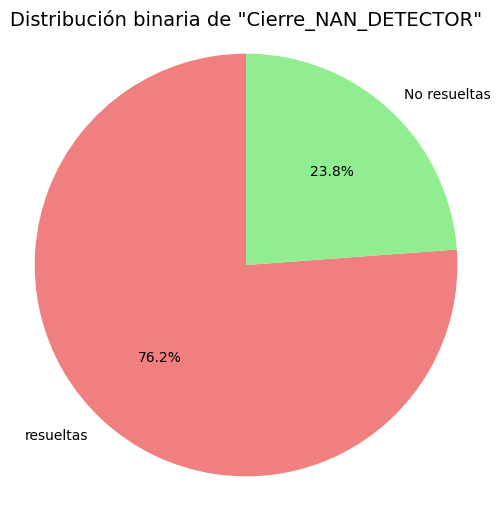

In [882]:
pieplot_binaria(df_merged,'Cierre_NAN_DETECTOR','No resueltas','resueltas')

## 4.2. ¿En que departamentos tengo la mayoria de incidentes?
El diagrama de Pareto muestra que la mayoría de los incidentes se concentran en pocos departamentos, siendo Cundinamarca el principal con cerca del 45% de los casos (850 incidentes). Junto con Boyacá, suman el 70% del total, lo que confirma el principio de Pareto. Esta concentración indica la necesidad de priorizar recursos y estrategias en Cundinamarca y Boyacá para maximizar el impacto de las acciones correctivas y preventivas.



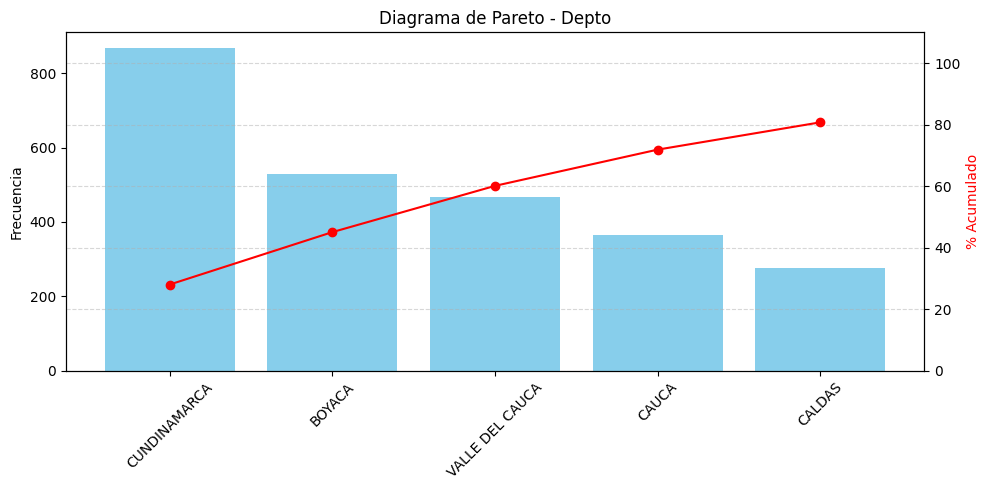

In [883]:
pareto(df_merged,'Depto')

## 4.3. ¿que prioridad tengo la mayoria de incidentes?:
El diagrama de Pareto muestra que la mayoría de incidentes se asignan a un plazo de un año, concentrando más del 40%. Las tres primeras categorías suman cerca del 70%, lo que indica una fuerte concentración en tiempos largos.






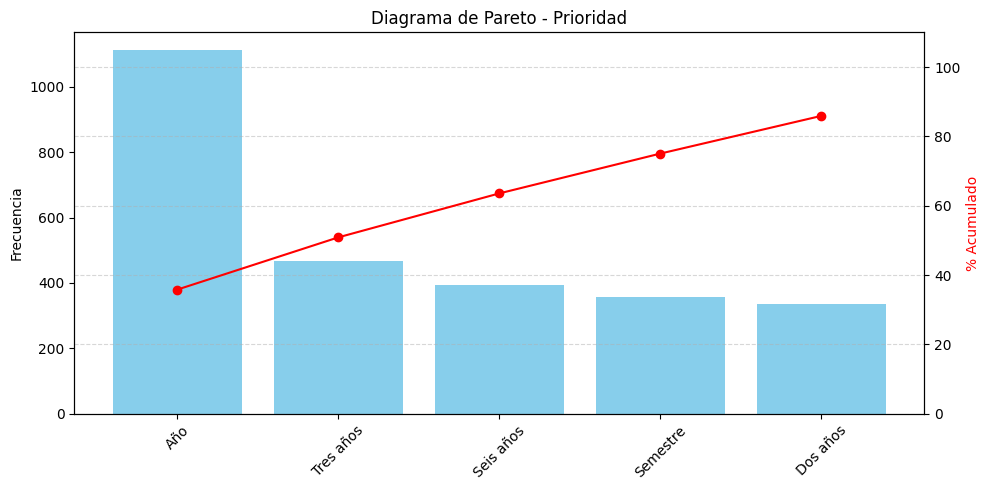

In [884]:
pareto(df_merged,'Prioridad')

## 4.2. ¿Por cuantos estados ha pasado una incidencia?
El análisis del boxplot revela que el rango intercuartílico compacto entre 1.5 y 3 incidentes confirma esta concentración, mientras que la presencia de un valor atípico de aproximadamente 7 incidentes representa más del triple del promedio nacional, evidenciando una distribución no uniforme. Esta configuración sugiere que mientras la mayoría de estados mantienen niveles controlados de incidencias, existe al menos un estado que concentra una cantidad desproporcionadamente alta de casos, lo cual requiere investigación específica para identificar los factores causales de esta concentración excepcional.



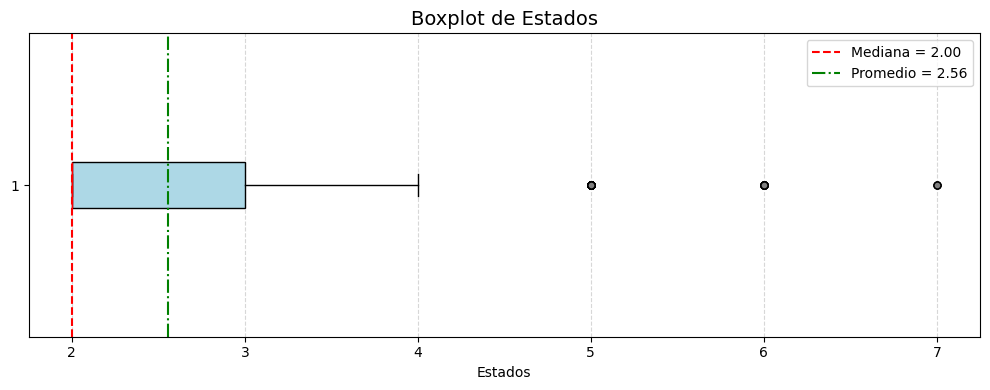

In [885]:
boxplot_variable(df_merged, 'Estados')

## 4.3. ¿En que momentos se abren mas incidencias?
La tendencia anual presenta tres fases: crecimiento explosivo (2004-2008) de cero a 300+ casos, estabilización volátil (2009-2017) con fluctuaciones entre 180-320 incidentes y picos en 2008, 2015 y 2017, y declive abrupto (2018-2019) cayendo a menos de 50 casos. Los años críticos (2008, 2015, 2017) sugieren eventos específicos relacionados con cambios organizacionales o implementación de sistemas. La tendencia muestra comportamiento cíclico con intervalos de 7-8 años entre picos.

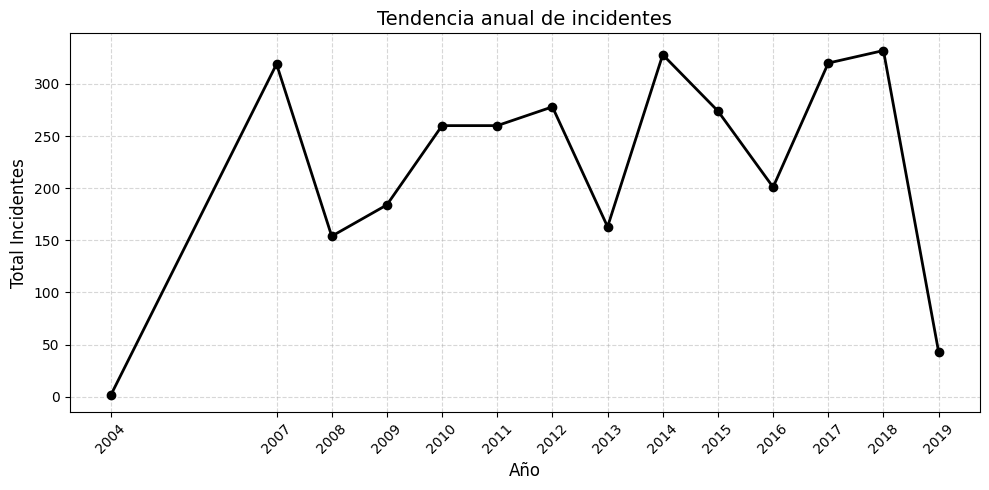

In [886]:
grafico_tendencia_anual(df_merged,'Creacion_year','incidentes_counter')

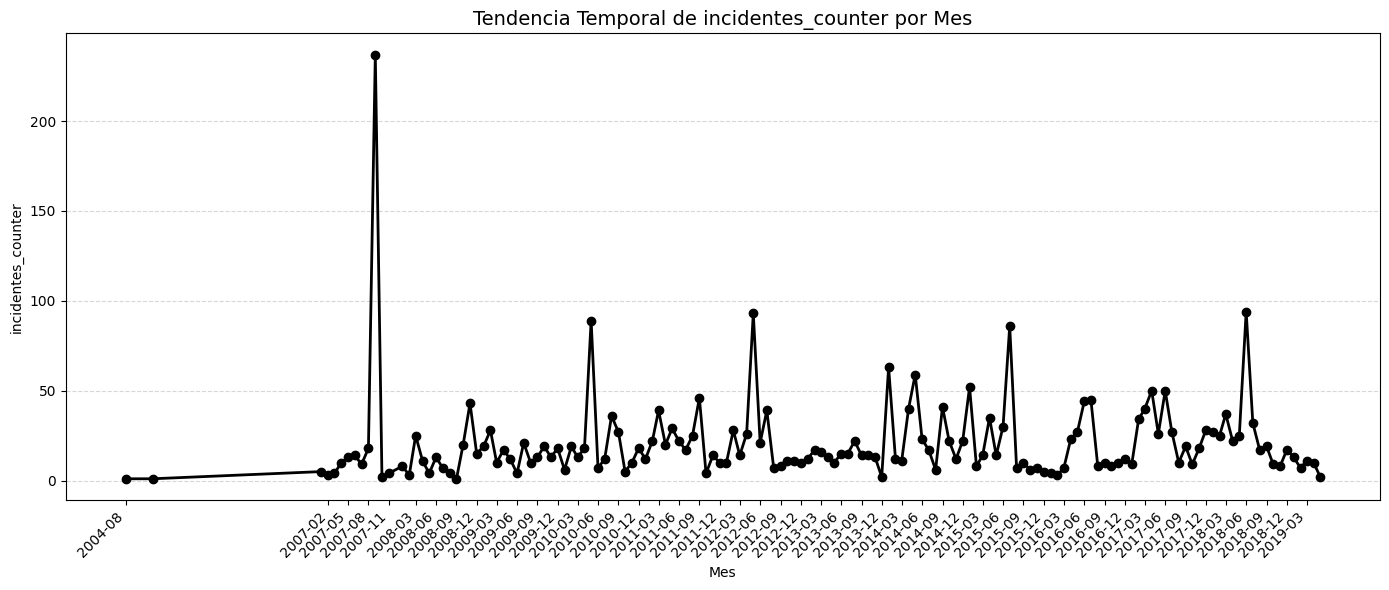

In [887]:
tendencia_temporal(df_merged, 'Creacion', 'incidentes_counter')

## 4.4. ¿Dias que llevan de mas las incidencias no cerradas?:
El boxplot muestra un exceso crítico en el tiempo de cierre de incidencias no resueltas, con una mediana de 2168 días (≈6 años) y extremos de hasta 6000 días. El 75% supera los 3000 días, reflejando retrasos sistemáticos. Esta situación evidencia una falla grave en la gestión, con demoras promedio de 6 años por caso.

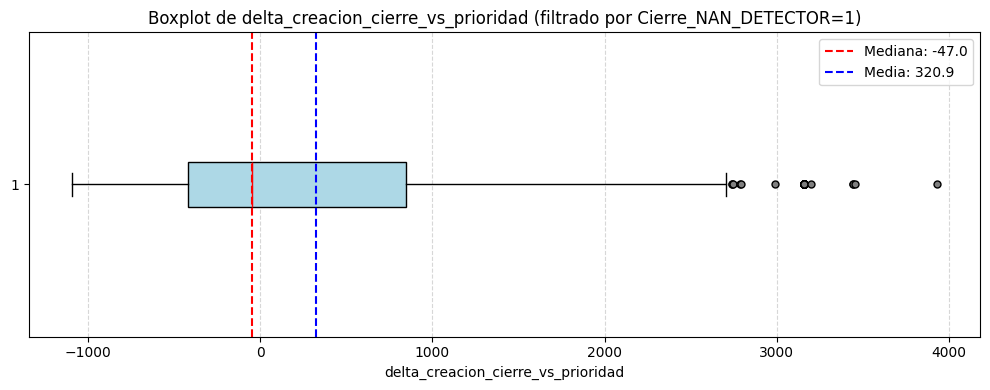

In [888]:
boxplot_filtrado(df_merged, 'delta_creacion_cierre_vs_prioridad', 'Cierre_NAN_DETECTOR', 1)


## 4.5. ¿Que tipos de incidencias son las que mas exiten?
La distribución revela una ligera predominancia de incidencias relacionadas con "Vegetación", representando aproximadamente el 54% frente al 46% de "Construcciones".

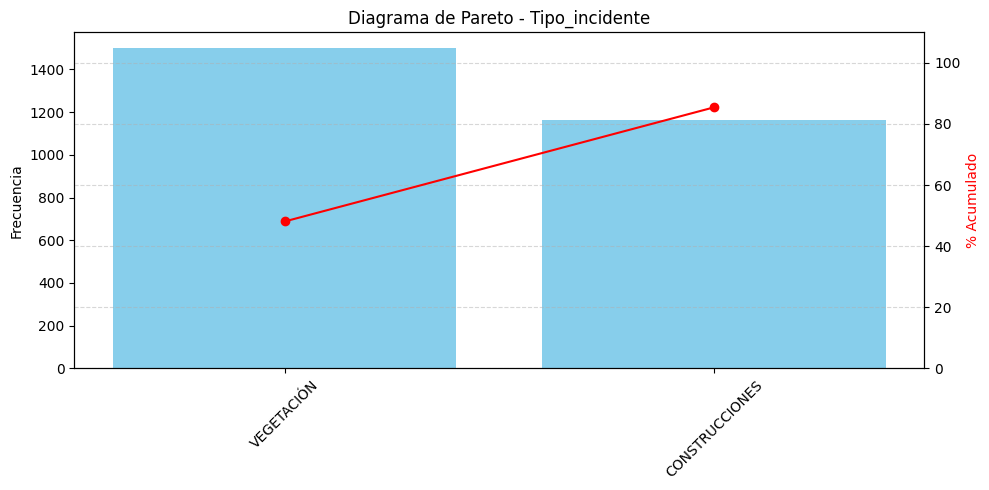

In [889]:
pareto(df_merged,'Tipo_incidente')

## 4.6. ¿Que porcentaje de peticiones cumpli contando desde la fecha de creacion?


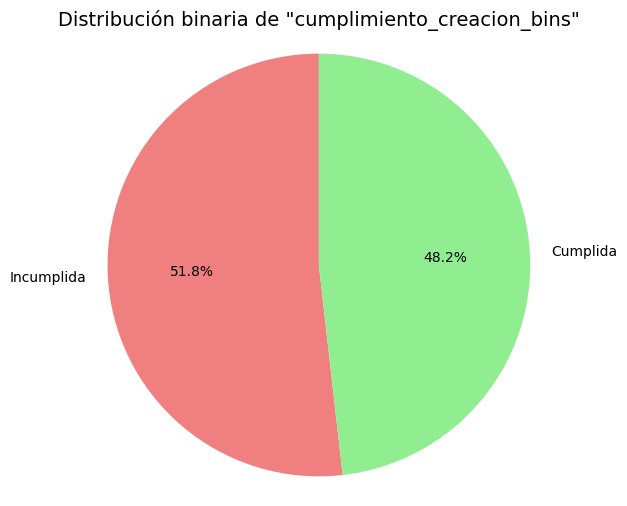

In [890]:
pieplot_binaria(df_merged,'cumplimiento_creacion_bins','Cumplida','Incumplida')

## 4.7. ¿Que porcentaje de peticiones cumpli contando desde la fecha de inicio?


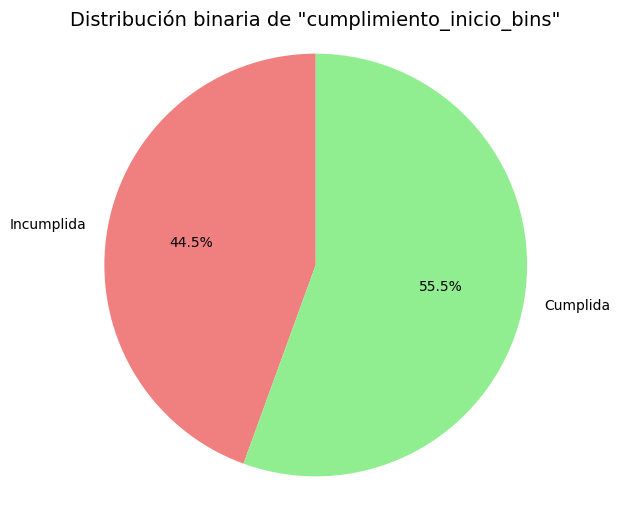

In [891]:
pieplot_binaria(df_merged,'cumplimiento_inicio_bins','Cumplida','Incumplida')

# 5. Analisis Bivariado

### 5.1. ¿Entre mas dias hayan de prioridad se deberan mas dias?




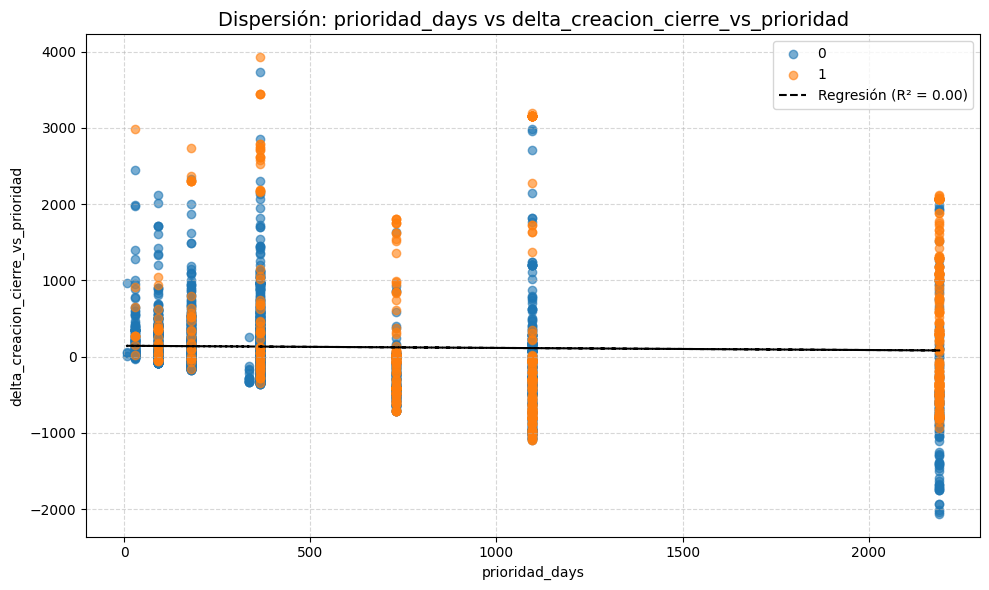

In [892]:
dispersion_con_r2_colores(df_merged,'prioridad_days','delta_creacion_cierre_vs_prioridad','Cierre_NAN_DETECTOR')

### 5.2. ¿Entre mas dias hayan de creacion a inicio pasen se deberan mas dias?




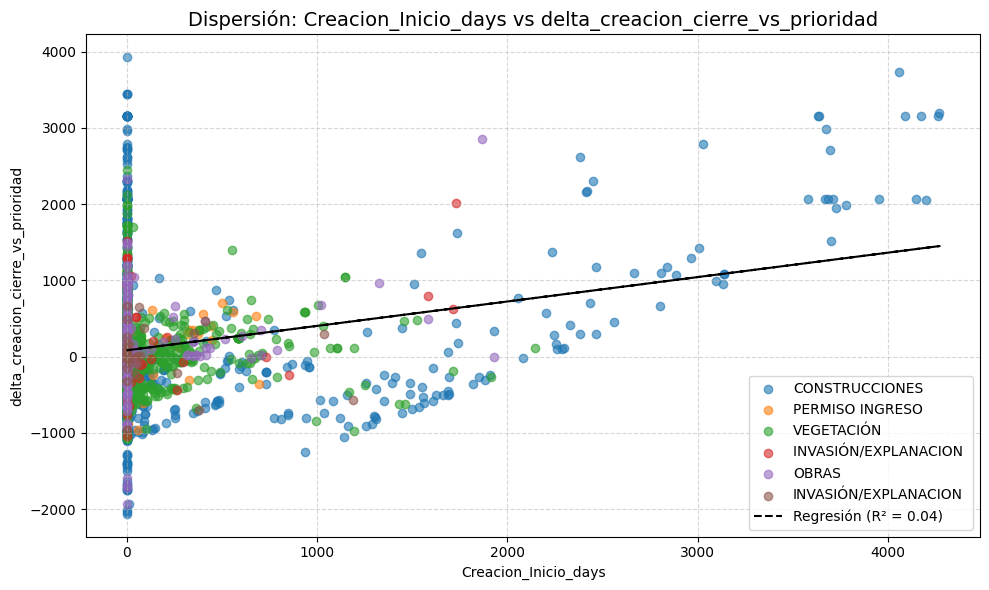

In [893]:
dispersion_con_r2_colores(df_merged,'Creacion_Inicio_days','delta_creacion_cierre_vs_prioridad','Tipo_incidente')

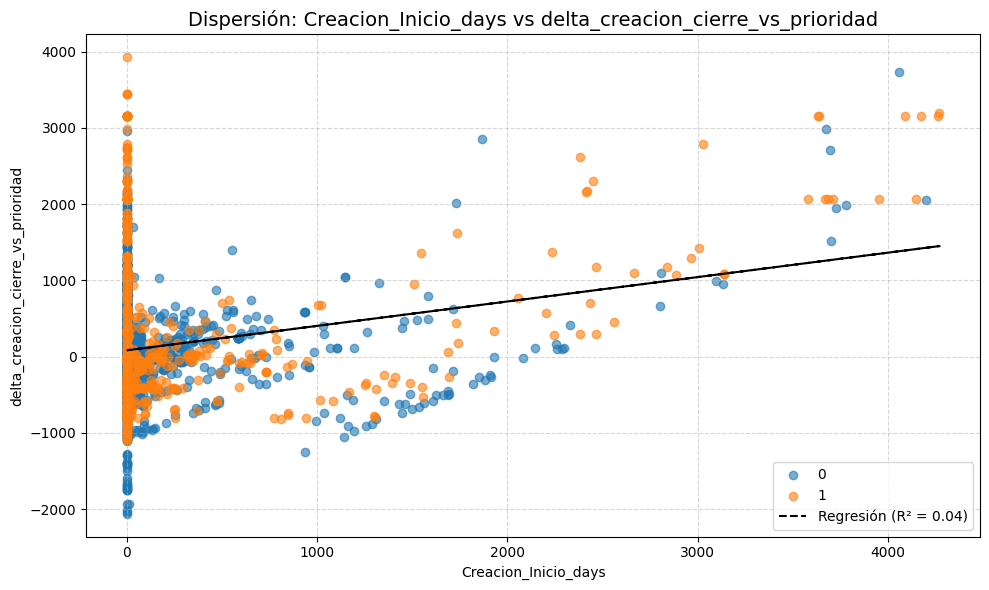

In [894]:
dispersion_con_r2_colores(df_merged,'Creacion_Inicio_days','delta_creacion_cierre_vs_prioridad','Cierre_NAN_DETECTOR')

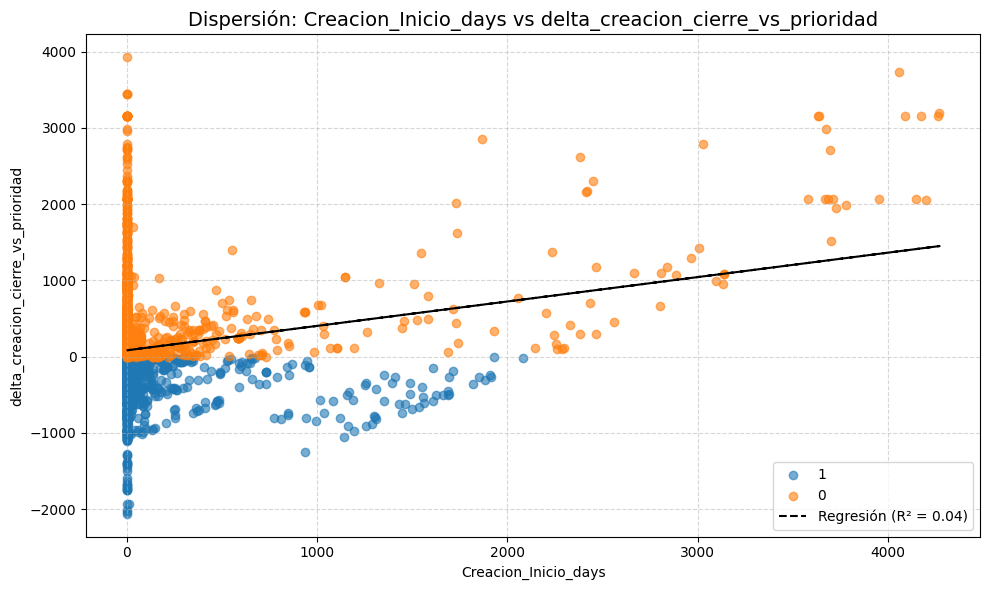

In [895]:
dispersion_con_r2_colores(df_merged,'Creacion_Inicio_days','delta_creacion_cierre_vs_prioridad','cumplimiento_creacion_bins')

### 5.3. Correlacion entre prioridad y tipo de incidente

In [896]:
chi_square_pval(df_merged,'Estado','Prioridad')

(np.float64(1.0956910148675928e-243), 'relación alta')

In [897]:
chi_square_pval(df_merged,'Tipo_incidente','Depto')

(np.float64(5.824066416556121e-68), 'relación alta')

# 6. ANALISIS DE FECHAS

## 6.1.Tiempo de vida de un incidente

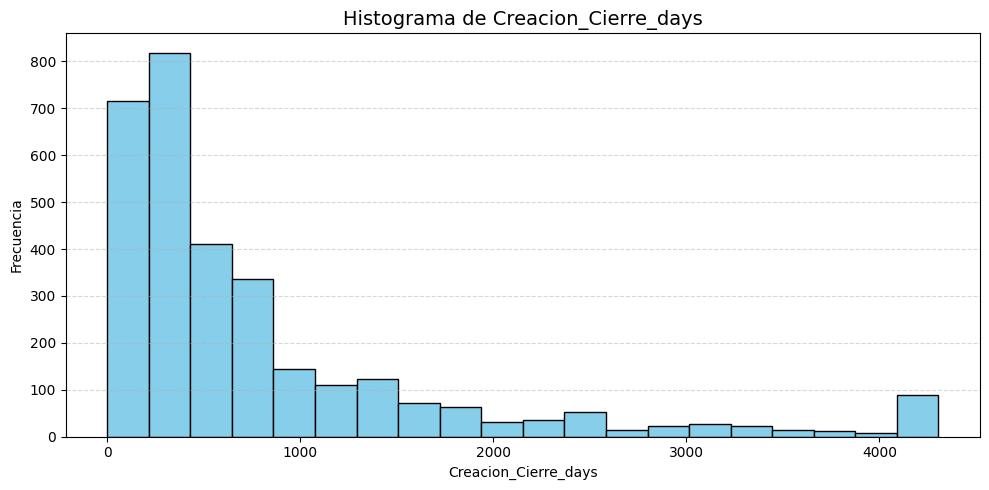

In [898]:
histograma_variable(df_merged,'Creacion_Cierre_days')

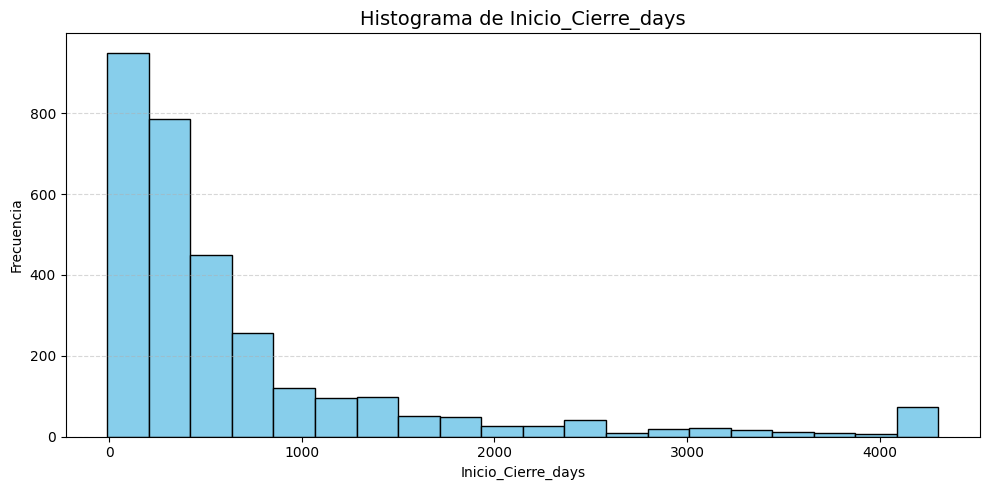

In [899]:
histograma_variable(df_merged,'Inicio_Cierre_days')

## 6.2. ¿Cuanto tardó en iniciar la solucion?

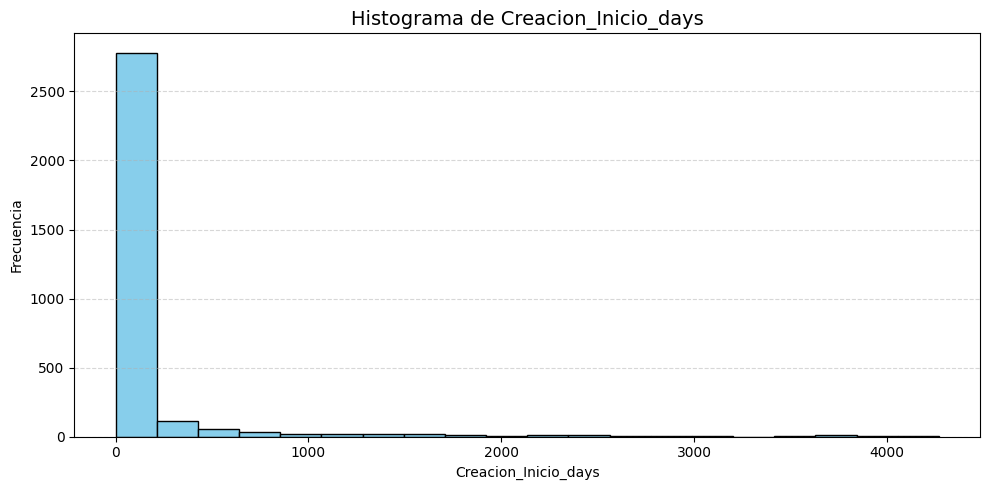

In [900]:
histograma_variable(df_merged,'Creacion_Inicio_days')

## 6.3. Cumplimiento de prioridad

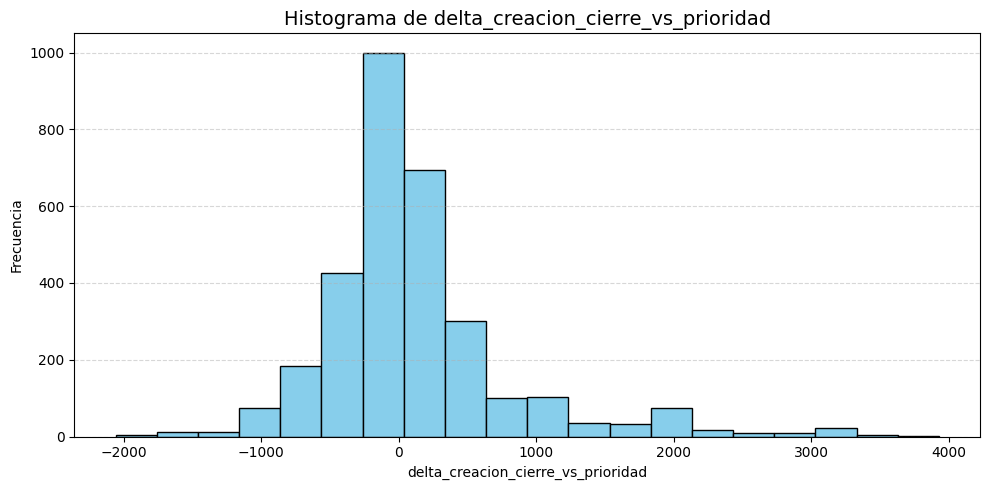

In [901]:
histograma_variable(df_merged,'delta_creacion_cierre_vs_prioridad')

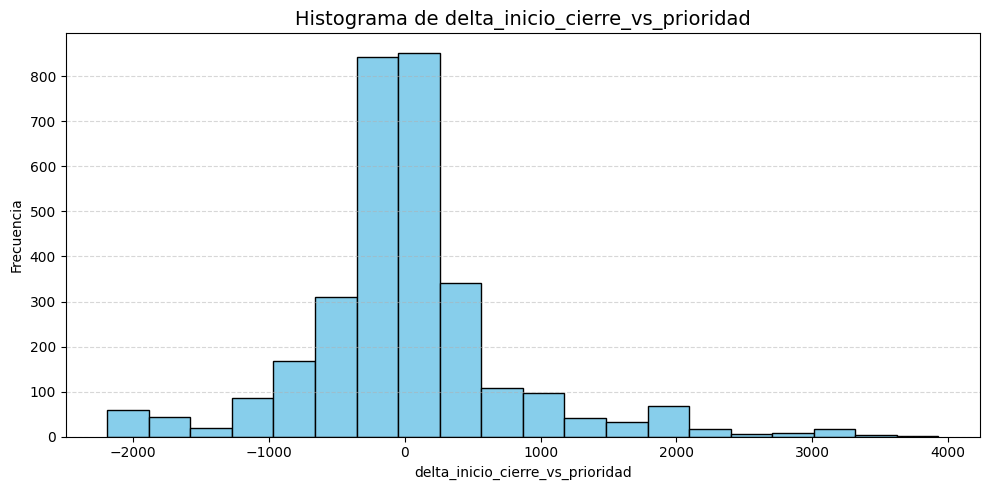

In [902]:
histograma_variable(df_merged,'delta_inicio_cierre_vs_prioridad')

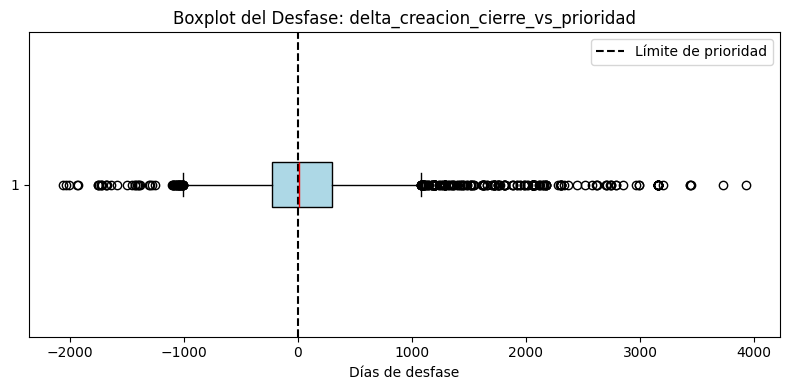

In [903]:
boxplot_desfase(df_merged, 'delta_creacion_cierre_vs_prioridad')

## 6.4. INCIDENCIAS VENCIDAS

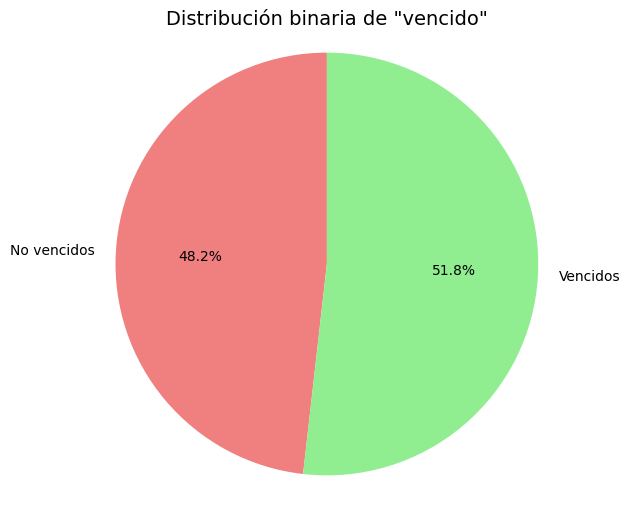

In [904]:
pieplot_binaria(df_merged,'vencido','Vencidos','No vencidos')

In [905]:
# Convertir a datetime, marcando errores como NaT
df_merged['Creacion'] = pd.to_datetime(df_merged['Creacion'], errors='coerce')
df_merged['Creacion_limite'] = pd.to_datetime(df_merged['Creacion_limite'], errors='coerce')

# Encontrar fechas inválidas (NaT = Not a Time)
fechas_invalidas = df_merged[df_merged['Creacion'].isna()]
print("Fechas inválidas:")
print(fechas_invalidas)

# Encontrar rangos inconsistentes
df_merged['rango_valido'] = df_merged['Creacion'] <= df_merged['Creacion_limite']
rangos_invalidos = df_merged[~df_merged['rango_valido']]
print("\nRangos inválidos:")
print(rangos_invalidos)

Fechas inválidas:
Empty DataFrame
Columns: [Incidente, Estructura, Tipo_incidente, Estado, Prioridad, Creacion, Inicio, Cierre, estado_interes, Creacion_Inicio_days, Creacion_Cierre_days, Inicio_Cierre_days, Incidente_Estructura_KEY, Cierre_NAN_DETECTOR, incidentes_counter, Creacion_year, Creacion_month, Creacion_year_month, Creacion_month_counter, Inicio_year, Inicio_month, Inicio_year_month, Inicio_month_counter, Serie, Depto, Municipio, Vereda, Cia, Latitud, Longitud, Estado_1, Estado_2, Estado_3, Estado_4, Estado_5, Estado_6, Estado_7, Estados, prioridad_days, dias_desde_creacion, dias_desde_inicio, delta_creacion_cierre_vs_prioridad, delta_inicio_cierre_vs_prioridad, cumplimiento_creacion, cumplimiento_inicio, cumplimiento_creacion_bins, cumplimiento_inicio_bins, Creacion_limite, vencido]
Index: []

[0 rows x 49 columns]

Rangos inválidos:
Empty DataFrame
Columns: [Incidente, Estructura, Tipo_incidente, Estado, Prioridad, Creacion, Inicio, Cierre, estado_interes, Creacion_Inicio_d

# 7. ANALISIS ESPACIAL


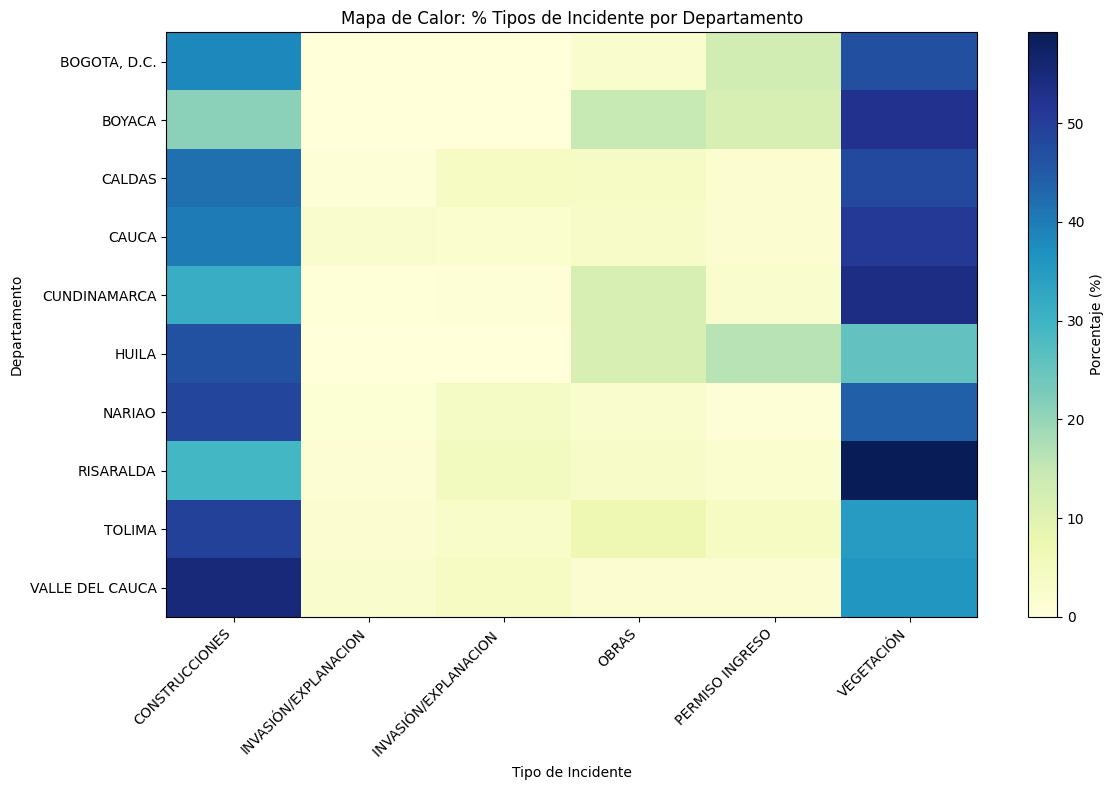

In [907]:
hmap(df_merged, 'Tipo_incidente', 'Depto')


ANÁLISIS DE INCIDENTES POR TIPO Y UBICACIÓN ESPACIAL

1. ANÁLISIS POR TIPO DE INCIDENTE
----------------------------------------
Frecuencia de incidentes por tipo:
  VEGETACIÓN: 1,499 incidentes (48.08%)
  CONSTRUCCIONES: 1,165 incidentes (37.36%)
  OBRAS: 236 incidentes (7.57%)
  PERMISO INGRESO: 125 incidentes (4.01%)
  INVASIÓN/EXPLANACION : 61 incidentes (1.96%)
  INVASIÓN/EXPLANACION: 32 incidentes (1.03%)


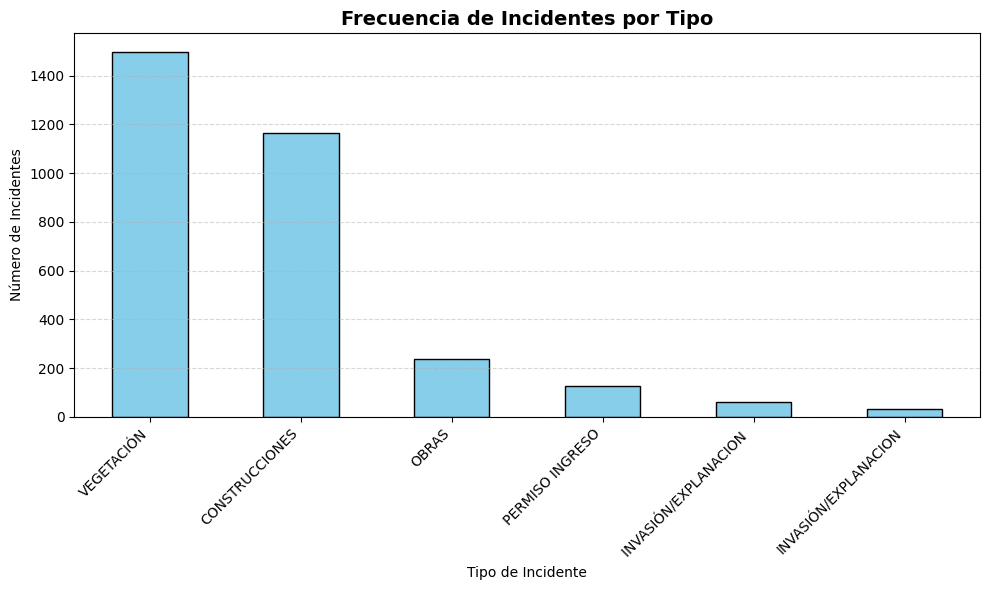

In [908]:
analizar_incidentes_espacial(df_merged)

# 8. Se plantea la realización de un PBI de control para llevar trazabilidad de las incidencias